# Prostate Imaging Test - Segmentation

## Imports

In [297]:
import nibabel as nb
import dicom2nifti
import shutil

from sklearn.model_selection import train_test_split
from skimage.transform import resize

import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

import scipy.ndimage
from scipy.ndimage import zoom

from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import Resize
# import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F

## Data Exploration & Pre-processing

### View masked images

In [2]:
masked1 = nb.load('Dataset002_Prostate/lesions/MaskedImages/ProstateX-0000_t2_tse_tra_4.nii_overlay.nii')
print(masked1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (500, 500, 4)
affine:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 500 500   4   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quat

In [3]:
masked1_fdata = masked1.get_fdata()
print(masked1_fdata)

[[[255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  ...
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]]

 [[255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  ...
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]]

 [[255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  ...
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]]

 ...

 [[255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  ...
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]]

 [[255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  ...
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]]

 [[255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  ...
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]
  [255. 255. 255. 255.]]]


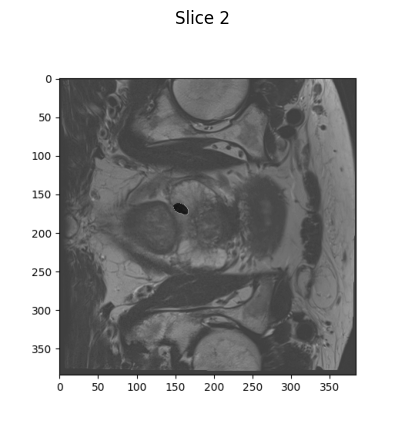

In [4]:
slice_index = masked1_fdata.shape[2] // 2
slice_data = masked1_fdata[:, :, slice_index]

plt.figure(figsize=(5, 5))
plt.imshow(slice_data, cmap='grey')
plt.title(f'Slice {slice_index}')
plt.axis('off')
plt.show()

### Resize images and masks to match

In [110]:
def resize_image(img, new_shape):
    if len(img.shape) != len(new_shape):
        if len(img.shape) < len(new_shape):
            img = np.expand_dims(img, axis=-1)
        else:
            new_shape = new_shape + (1,)
    
    zoom_factors = np.array(new_shape) / np.array(img.shape)
    resized_img = scipy.ndimage.zoom(img, zoom_factors, order=1) # order=1 for linear interpolation
    return resized_img

In [127]:
img1 = nb.load('Dataset002_Prostate/lesions/Images/T2/ProstateX-0000_t2_tse_tra_4.nii.gz')
print(img1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (384, 384, 19)
affine:
[[-4.99999613e-01  1.00167548e-10 -3.77059053e-03  5.76854362e+01]
 [ 1.99305243e-04  4.74188238e-01 -9.51439738e-01 -9.92510300e+01]
 [-5.95989870e-04  1.58573419e-01  2.84512711e+00 -8.78143768e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  3 384 384  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.    0.5   0.5   3.    5.66  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min      

In [131]:
img1_fdata = img1.get_fdata()
print(img1_fdata.shape)

(384, 384, 19)


In [133]:
mask1 = nb.load('Dataset002_Prostate/lesions/Masks/T2/ProstateX-0000-Finding1-t2_tse_tra_ROI.nii.gz')
print(mask1)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (384, 384, 19)
affine:
[[-4.99999567e-01 -4.75556197e-06 -3.94588803e-03  5.76854362e+01]
 [ 2.04060917e-04  4.74188225e-01 -9.51439683e-01 -9.92510300e+01]
 [-6.25206092e-04  1.58573412e-01  2.84512688e+00 -8.78143768e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 384 384  19   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.   0.5  0.5  3.   0.   0.   0.   0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0


In [135]:
mask1_fdata = mask1.get_fdata()
print(mask1_fdata.shape)

(384, 384, 19)


### Load dataset and define transforms

In [367]:
class ProstateDataset2(Dataset):
    def __init__(self, img_path, target_path):
        super().__init__()
        self.imgs = glob(os.path.join(img_path, "*.nii.gz"))
        self.targets = glob(os.path.join(target_path, "*.nii.gz"))
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        
        image = nb.load(self.imgs[idx]).get_fdata()
        label = nb.load(self.targets[idx]).get_fdata()
        
        size = (384, 384, 384)
        
        # image = resize(image, size, order=1, preserve_range=True)
        # label = resize(label, size, order=0, preserve_range=True)
        
        # Resize images and labels
        image = resize(image, size, order=1, preserve_range=True, anti_aliasing=False)
        label = resize(label, size, order=0, preserve_range=True, anti_aliasing=False)
        
        # Convert to PyTorch tensor and adjust dimensions
        image = torch.tensor(image)
        label = torch.tensor(label).unsqueeze(0) 
        
        return image, label

In [368]:
def makeLoader():
    dataloader = DataLoader(ProstateDataset2(
        img_path = 'Dataset002_Prostate/lesions/ResizedImages',
        target_path= 'Dataset002_Prostate/lesions/ResizedMasks'
    ), batch_size=4, shuffle=True)
    
    return dataloader

In [369]:
trainloader = makeLoader()
valloader = makeLoader()
testloader = makeLoader()

## Define models and train

In [370]:
class DoubleConv3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3d, self).__init__()

        self.stack = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 4, 1, 1),
            nn.ReLU(),
            nn.Conv3d(out_channels, out_channels, 4, 1, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.stack(x)

In [371]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        inn = 4
        out = 2
        mid = [112, 224, 448]

        self.encoder = nn.ModuleList()
        self.bottom  = DoubleConv3d(mid[-1], 2*mid[-1]) # should both be mid[-1]?
        self.decoder = nn.ModuleList()
        self.end     = nn.Conv2d(mid[0], 1*out, 1)

        self.maxpool = nn.MaxPool3d(2, 2)
        #self.linear  = Linear(65536, 10)

        for dim in mid:
            self.encoder.append(DoubleConv3d(inn, dim))
            inn = dim

        for dim in mid[::-1]:
            self.decoder.append(nn.ConvTranspose3d(2*dim, dim, 2, 2))
            self.decoder.append(DoubleConv3d(2*dim, dim))


    def forward(self, x):
        connections = []

        for i in range(len(self.encoder)):
            module = self.encoder[i]

            x = module(x)
            connections.append(x)
            x = self.maxpool(x)

        x = self.bottom(x)

        for i in range(len(self.decoder)):
            module = self.decoder[i]
            x = module(x)

            if i % 2 == 0: # ConvTranspose3d
                connection = connections.pop()
                x = torch.cat((connection, x), dim=1)
        
        x = self.end(x)

        # x = x.view(x.size(0), -1)
        #x = self.linear(x)

        return x


In [372]:
def dice(ytrue, ypred):
    if ytrue.dim() == 2:
        inter = torch.dot(ytrue[i].reshape(-1), ypred[i].reshape(-1))

        cardA = torch.sum(ytrue)
        cardB = torch.sum(ypred)

        num = 2 * inter     + 1e-6
        den = cardA + cardB + 1e-6

        return num / den

    elif ytrue.dim() == 3:
        batch_size = ytrue.shape[0]
        total = 0

        for i in range(batch_size):
            total += dice(ytrue[i, ...], ypred[i, ...])

        return total / batch_size
    
    return None

In [373]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_unet(net, trainloader, valloader, optimizer, loss_function, n_epochs):
    net = net.float()

    t_size = len(trainloader.dataset)
    v_size = len(valloader.dataset)

    graphs = {
        'train_loss' : [],
        'val_loss'   : [],
        'train_dice' : [],
        'val_dice'   : []
    }

    for epoch in range(1, n_epochs+1):
        net.train()
        y_loss = 0
        y_dice = 0
        w_loss = 0
        w_dice = 0

        for X_batch, (X, y) in enumerate(trainloader):
            X, y = X.to(device), y.to(device)
            
            y_pred = net(X.float())
            y_loss = loss_function(y_pred, y)
            y_dice = dice(y, y_pred)

            optimizer.zero_grad()
            y_loss.backward()
            optimizer.step()

            if X_batch % 100 == 0:
                net.eval()
                w_loss = 0
                w_dice = 0

                for V_batch, (V, w) in enumerate(valloader):
                    V, w = V.to(device), w.to(device)

                    w_pred  = net(V.float())
                    w_loss  = loss_function(w_pred, w)
                    w_dice += dice(w, w_pred)

                w_loss = w_loss / v_size
                w_dice = w_dice / v_size

            graphs['train_loss'].append(y_loss.item())
            graphs['train_dice'].append(y_dice)
            graphs['val_loss'].append(w_loss.item())
            graphs['val_dice'].append(w_dice)

In [374]:
unet = UNet()

criterion = nn.BCELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)
num_epochs = 10

In [375]:
train_unet(unet, trainloader, valloader, optimizer, criterion, n_epochs=num_epochs)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 24972849664 bytes.

## Archive - Disregard

May be helpful for later use

### Convert DICOM to NIFTI

In [ ]:
output_dir = 'Dataset001_Prostate/imagesTr'
dicom_dir = 'Dataset001_Prostate/imagesTr'

dicom2nifti.convert_directory(dicom_dir, output_dir)

### Rename and gzip files

In [3]:
def main():
    folder_path = 'Dataset002_Prostate/imagesTr'
    for count, filename in enumerate(sorted(os.listdir(folder_path))):
        dst = f"PCA_" + str(count).zfill(3) + ".nii"
        
        src = f"{folder_path}/{filename}"
        dst = f"{folder_path}/{dst}"
        
        os.rename(src, dst)

if __name__ == '__main__':
    main()

In [ ]:
import gzip

def gzip_dir(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        if os.path.isfile(file_path) and not filename.endswith('.gz'):
            gzipped_file_path=f"{file_path}.gz"
        
        with open(file_path, 'rb') as f_in:
            with gzip.open(gzipped_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [ ]:
directory = 'Dataset001_Prostate/imagesTr'
gzip_dir(directory)

### Resizing outtakes

In [25]:
nifti_file_path = 'Dataset002_Prostate/lesions/Images/T2/ProstateX-0000_t2_tse_tra_4.nii.gz'
nifti_img = nb.load(nifti_file_path)
nifti_data = nifti_img.get_fdata()
original_shape = nifti_data.shape
print(original_shape)

(384, 384, 19)


In [32]:
slice_index = original_shape[2] // 2
selected_slice = nifti_data[:, :, slice_index]

In [33]:
output_size = (128, 128)
zoom_factors = [output_size[i] / selected_slice.shape[i] for i in range(2)]

In [34]:
resized_slice = zoom(selected_slice, zoom_factors, order=3) 

In [37]:
resized_img = nb.Nifti1Image(resized_slice, affine=nifti_img.affine)

In [38]:
output_nifti_file_path = 'Dataset002_Prostate/lesions/ResizedImages/ProstateX-0000_t2_tse_tra_4-RESIZED.nii.gz'
nb.save(resized_img, output_nifti_file_path)

In [39]:
resized = nb.load('Dataset002_Prostate/lesions/ResizedImages/ProstateX-0000_t2_tse_tra_4-RESIZED.nii.gz')
resized_data = resized.get_fdata()
print(resized_data.shape)

(128, 128)


In [40]:
def resize_images(input_dir, output_dir, output_size=(128, 128)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for filename in os.listdir(input_dir):
        nifti_file_path = os.path.join(input_dir, filename)
        output_file_path = os.path.join(output_dir, filename)
        
        nifti_img = nb.load(nifti_file_path)
        nifti_data = nifti_img.get_fdata()
        
        slice_index = nifti_data.shape[2] // 2
        selected_slice = nifti_data[:, :, slice_index]
        
        zoom_factors = [output_size[i] / selected_slice.shape[i] for i in range(2)]
        
        resized_slice = zoom(selected_slice, zoom_factors, order=3)
        
        resized_img = nb.Nifti1Image(resized_slice, affine=nifti_img.affine)
        
        nb.save(resized_img, output_file_path)

In [41]:
input_dir = 'Dataset002_Prostate/lesions/Images/T2'
output_dir = 'Dataset002_Prostate/lesions/ResizedImages'

resize_images(input_dir, output_dir)

In [43]:
nifti_img = nb.load('Dataset002_Prostate/lesions/ResizedImages/ProstateX-0001_t2_tse_tra_10.nii.gz')
nifti_data = nifti_img.get_fdata()
print(nifti_data.shape)

(128, 128)


In [44]:
mask_img = nb.load('Dataset002_Prostate/lesions/Masks/T2/ProstateX-0000-Finding1-t2_tse_tra_ROI.nii.gz')
mask_data = mask_img.get_fdata()
print(mask_data.shape)

(384, 384, 19)


In [45]:
mask_input_dir = 'Dataset002_Prostate/lesions/Masks/T2'
mask_output_dir = 'Dataset002_Prostate/lesions/ResizedMasks'

resize_images(mask_input_dir, mask_output_dir)

In [222]:
# (torch.Size([8, 1, 128, 128])) that is different to the input size (torch.Size([128, 2, 128, 128]))

target_tensor = torch.randn(128, 2, 128, 128)  # Example target tensor

# Reshape the tensor
target_tensor = target_tensor.view(8, -1, 128, 128)[:,:1,:,:]

# Check the shape
print(target_tensor.shape)

torch.Size([8, 1, 128, 128])
